<h2><center><font color=#000000> Electric Power Consumption Forecasting </font></center></h2>
<br> 


# I. Introduction
Forecasting electricity consumption for a single point of consumption, monitored over an extended period of time, is an important problem in the field of energy management and intelligent monitoring systems. A correct estimate of future consumption allows for the optimization of energy use and supports decision-making based on real data. In this project, the problem of forecasting electricity consumption based on historical time series is addressed, using a real dataset available on Kaggle.

The analyzed data are collected at regular time intervals and include both energy consumption values ​​and associated meteorological variables, which gives the problem a multivariate and nonlinear character. Due to the short-term and long-term temporal dependencies present in the data, Deep Learning models based on Recurrent Neural Networks, such as Long Short-Term Memory (LSTM) and Gated Recurrent Unit (GRU), are suitable for this task, being recognized in the specialized literature for the performances obtained in forecasting energy time series.

GitHub Repo: https://github.com/Geo1420/Deep_Learning_Electric_Power_Consumption_Forecasting/tree/main

# II. Deep Learning Methodology

To address the problem of electric energy consumption forecasting, a Deep Learning approach based on Recurrent Neural Networks (RNNs) is employed, specifically designed for time series processing. In particular, the Long Short-Term Memory (LSTM) and Gated Recurrent Unit (GRU) architectures are investigated, as they were proposed to overcome the limitations of classical RNNs in capturing long-term temporal dependencies.

The adopted model is structured as a sequential neural network, where the input consists of a sequence of historical observations over a fixed temporal window (sequence length). The architecture includes one or more recurrent layers (LSTM or GRU), followed by a fully connected (Dense) layer responsible for generating the prediction for the future time horizon. This configuration enables the model to learn temporal and nonlinear relationships between the input variables and energy consumption.

Model training is performed using the Mean Squared Error (MSE) loss function and the Adam optimizer, while performance is evaluated through standard regression metrics. The choice of LSTM and GRU architectures is supported by foundational studies in the literature, which demonstrate their effectiveness in energy time series forecasting applications.

# III. Software Design and Implementation:

## Section 1. Importing Packages
This section imports the required Python libraries for data manipulation, visualization, preprocessing, model evaluation, and deep learning model construction. Additionally, random seeds are set to ensure reproducibility of the experimental results.

In [5]:
# =====================================================
# SECTION 1: Import Packages
# =====================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, GRU

# For reproducibility
np.random.seed(42)
tf.random.set_seed(42)


## Section 1. Load Dataset
The dataset is loaded from the CSV file, and the Datetime column is converted to time format and used as an index, ensuring the chronological ordering required for time series analysis.

In [6]:
# =====================================================
# SECTION 2: Load Dataset
# =====================================================
df = pd.read_csv("/kaggle/input/electric-power-consumption/powerconsumption.csv")
df['Datetime'] = pd.to_datetime(df['Datetime'])
df.sort_values('Datetime', inplace=True)
df.set_index('Datetime', inplace=True)
df.head()

,Temperature,Humidity,WindSpeed,GeneralDiffuseFlows,DiffuseFlows,PowerConsumption_Zone1,PowerConsumption_Zone2,PowerConsumption_Zone3
Datetime,,,,,,,,
2017-01-01 00:00:00,6.559,73.8,0.083,0.051,0.119,34055.69620,16128.87538,20240.96386
2017-01-01 00:10:00,6.414,74.5,0.083,0.070,0.085,29814.68354,19375.07599,20131.08434
2017-01-01 00:20:00,6.313,74.5,0.080,0.062,0.100,29128.10127,19006.68693,19668.43373
2017-01-01 00:30:00,6.121,75.0,0.083,0.091,0.096,28228.86076,18361.09422,18899.27711
2017-01-01 00:40:00,5.921,75.7,0.081,0.048,0.085,27335.69620,17872.34043,18442.40964


## Section 2. Data Visualization
This section performs an exploratory visual analysis of the data, highlighting the relationships between meteorological variables and energy consumption through a pairplot, as well as the evolution over time of electricity consumption for each area, using time series graphs.

/opt/conda/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


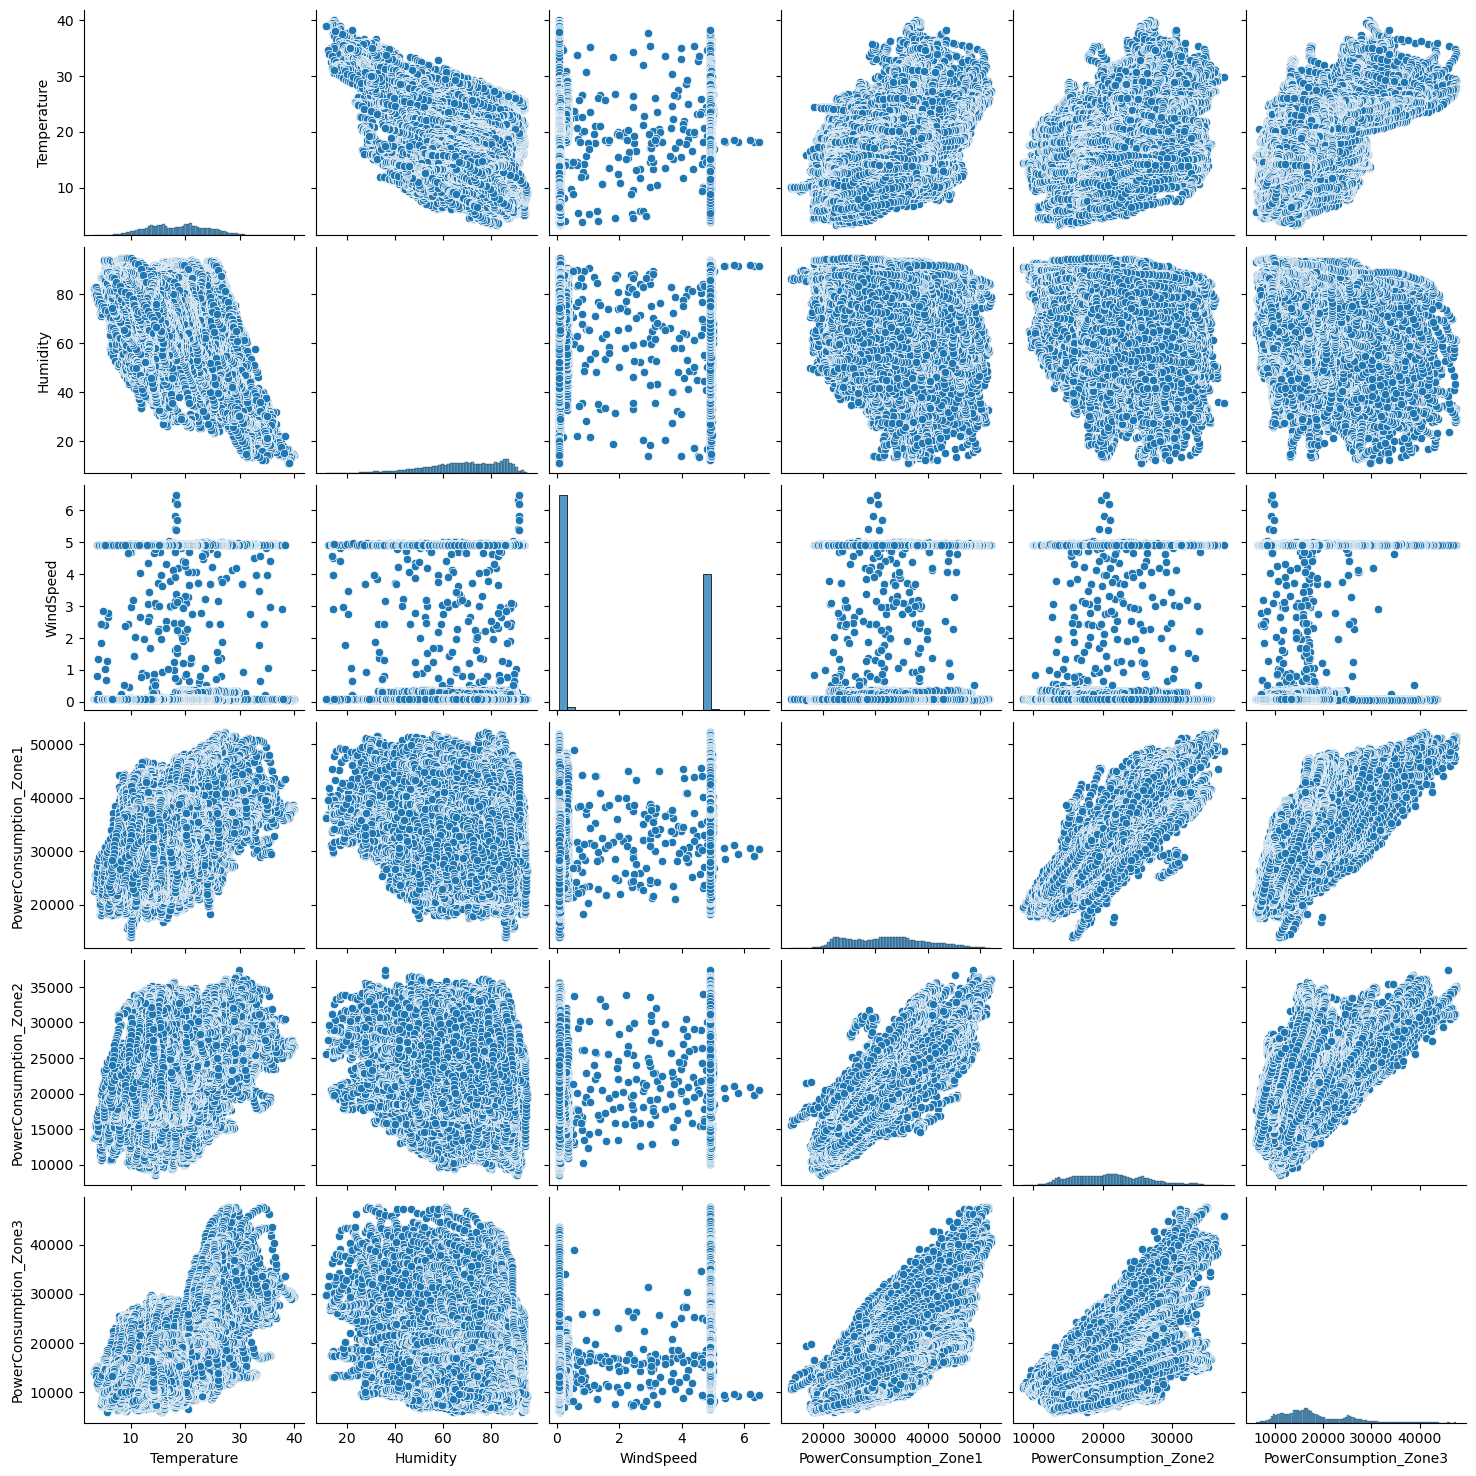

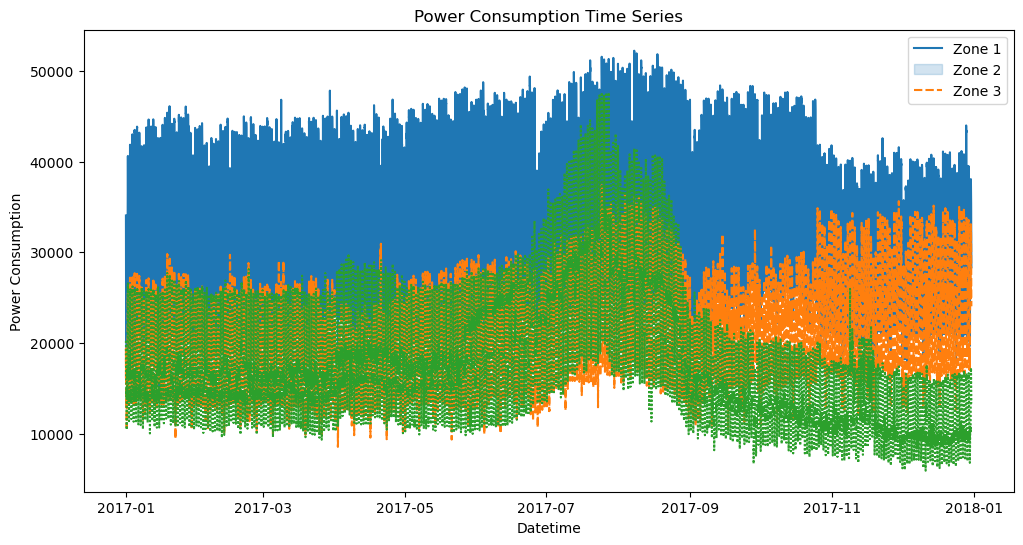

In [7]:
# =====================================================
# SECTION 3: Data Visualization
# =====================================================

# Pairplot for main features
sns.pairplot(df[['Temperature', 'Humidity', 'WindSpeed',
                 'PowerConsumption_Zone1', 'PowerConsumption_Zone2', 'PowerConsumption_Zone3']])
plt.show()

# Time series plot for each zone
plt.figure(figsize=(12,6))
sns.lineplot(data=df[['PowerConsumption_Zone1', 'PowerConsumption_Zone2', 'PowerConsumption_Zone3']])
plt.xlabel("Datetime")
plt.ylabel("Power Consumption")
plt.title("Power Consumption Time Series")
plt.legend(['Zone 1', 'Zone 2', 'Zone 3'])
plt.show()

## Section 4. Feature Scaling
In this step, the input variables (features) and targets (targets) are scaled between 0 and 1 using MinMaxScaler. The purpose of scaling is to bring all variables to the same scale, which improves the stability and training speed of LSTM and GRU models.

In [8]:
# =====================================================
# SECTION 4: Feature Scaling
# =====================================================
features = ['Temperature', 'Humidity', 'WindSpeed', 'GeneralDiffuseFlows']
targets = ['PowerConsumption_Zone1', 'PowerConsumption_Zone2', 'PowerConsumption_Zone3']

scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_scaled = scaler_X.fit_transform(df[features])
y_scaled = scaler_y.fit_transform(df[targets])

## Section 5. Create Time Series Sequences
In this section, the scaled data is transformed into temporal sequences for use by the LSTM and GRU models, each sequence having length SEQ_LENGTH (24 times, ~4 hours). The dataset is then split into training and test sets (80% / 20%) to allow for evaluation of the models' performance.

In [9]:
# =====================================================
# SECTION 5: Create Time Series Sequences
# =====================================================
def create_sequences(X, y, seq_length):
    X_seq, y_seq = [], []
    for i in range(len(X) - seq_length):
        X_seq.append(X[i:i+seq_length])
        y_seq.append(y[i+seq_length])
    return np.array(X_seq), np.array(y_seq)

SEQ_LENGTH = 24  # Using last 24 timesteps (~4 hours if 10-min interval)
X_seq, y_seq = create_sequences(X_scaled, y_scaled, SEQ_LENGTH)

# Split into train/test
split = int(0.8 * len(X_seq))
X_train, X_test = X_seq[:split], X_seq[split:]
y_train, y_test = y_seq[:split], y_seq[split:]

print("Training set shape:", X_train.shape, y_train.shape)
print("Test set shape:", X_test.shape, y_test.shape)

Training set shape: (41913, 24, 4) (41913, 3)
Test set shape: (10479, 24, 4) (10479, 3)


## Section 6: LSTM Model
This section builds and trains the LSTM model for energy consumption forecasting.

In [10]:
# =====================================================
# SECTION 6: LSTM Model
# =====================================================
model_lstm = Sequential([
    LSTM(50, activation='relu', input_shape=(SEQ_LENGTH, len(features))),
    Dense(3)  # One output per zone
])
model_lstm.compile(optimizer='adam', loss='mse')
model_lstm.summary()

# Train LSTM
lstm_history = model_lstm.fit(X_train, y_train,
                              validation_data=(X_test, y_test),
                              epochs=20,
                              batch_size=64,
                              verbose=2)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50)                11000     
                                                                 
 dense (Dense)               (None, 3)                 153       
                                                                 
Total params: 11,153
Trainable params: 11,153
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
655/655 - 12s - loss: 0.0191 - val_loss: 0.0252 - 12s/epoch - 19ms/step
Epoch 2/20
655/655 - 10s - loss: 0.0101 - val_loss: 0.0219 - 10s/epoch - 15ms/step
Epoch 3/20
655/655 - 10s - loss: 0.0087 - val_loss: 0.0218 - 10s/epoch - 15ms/step
Epoch 4/20
655/655 - 10s - loss: 0.0082 - val_loss: 0.0234 - 10s/epoch - 15ms/step
Epoch 5/20
655/655 - 10s - loss: 0.0080 - val_loss: 0.0224 - 10s/epoch - 15ms/step
Epoch 6/20
655/655 - 10s - loss: 

## Section 7. GRU Model
This section builds and trains the GRU (Gated Recurrent Unit) model for energy consumption forecasting.

In [11]:
# =====================================================
# SECTION 7: GRU Model
# =====================================================
model_gru = Sequential([
    GRU(50, activation='relu', input_shape=(SEQ_LENGTH, len(features))),
    Dense(3)
])
model_gru.compile(optimizer='adam', loss='mse')
model_gru.summary()

# Train GRU
gru_history = model_gru.fit(X_train, y_train,
                            validation_data=(X_test, y_test),
                            epochs=20,
                            batch_size=64,
                            verbose=2)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 50)                8400      
                                                                 
 dense_1 (Dense)             (None, 3)                 153       
                                                                 
Total params: 8,553
Trainable params: 8,553
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
655/655 - 11s - loss: 0.0214 - val_loss: 0.0249 - 11s/epoch - 17ms/step
Epoch 2/20
655/655 - 9s - loss: 0.0102 - val_loss: 0.0229 - 9s/epoch - 14ms/step
Epoch 3/20
655/655 - 9s - loss: 0.0092 - val_loss: 0.0222 - 9s/epoch - 14ms/step
Epoch 4/20
655/655 - 9s - loss: 0.0088 - val_loss: 0.0228 - 9s/epoch - 14ms/step
Epoch 5/20
655/655 - 9s - loss: 0.0082 - val_loss: 0.0224 - 9s/epoch - 14ms/step
Epoch 6/20
655/655 - 9s - loss: 0.0079 - 

## Section 8. Model Evaluation
This section deals with evaluating the predictive performance of the trained models and comparing the results between LSTM and GRU.

In [12]:
# =====================================================
# SECTION 8: Model Evaluation
# =====================================================
# Predictions
y_pred_lstm = model_lstm.predict(X_test)
y_pred_gru = model_gru.predict(X_test)

# Inverse scaling
y_test_inv = scaler_y.inverse_transform(y_test)
y_pred_lstm_inv = scaler_y.inverse_transform(y_pred_lstm)
y_pred_gru_inv = scaler_y.inverse_transform(y_pred_gru)

# Compute Metrics
for i, zone in enumerate(targets):
    mse_lstm = mean_squared_error(y_test_inv[:,i], y_pred_lstm_inv[:,i])
    mae_lstm = mean_absolute_error(y_test_inv[:,i], y_pred_lstm_inv[:,i])
    mse_gru = mean_squared_error(y_test_inv[:,i], y_pred_gru_inv[:,i])
    mae_gru = mean_absolute_error(y_test_inv[:,i], y_pred_gru_inv[:,i])
    
    print(f"{zone} - LSTM: MSE={mse_lstm:.2f}, MAE={mae_lstm:.2f} | GRU: MSE={mse_gru:.2f}, MAE={mae_gru:.2f}")


328/328 [==============================] - 1s 4ms/step
PowerConsumption_Zone1 - LSTM: MSE=13748871.05, MAE=2954.47 | GRU: MSE=15817139.78, MAE=3153.32
PowerConsumption_Zone2 - LSTM: MSE=32636573.08, MAE=4888.56 | GRU: MSE=33449363.80, MAE=4880.20
PowerConsumption_Zone3 - LSTM: MSE=35441509.03, MAE=5360.10 | GRU: MSE=29183631.18, MAE=4782.69


## Section 9. Plot Forecast vs Real
This section visualizes the predictions of the LSTM and GRU models compared to the actual consumption values ​​for the first 200 samples in the test set. The graphs allow for a visual assessment of the accuracy of each model across the three consumption areas and highlight how well the models follow the temporal trend of the actual data.

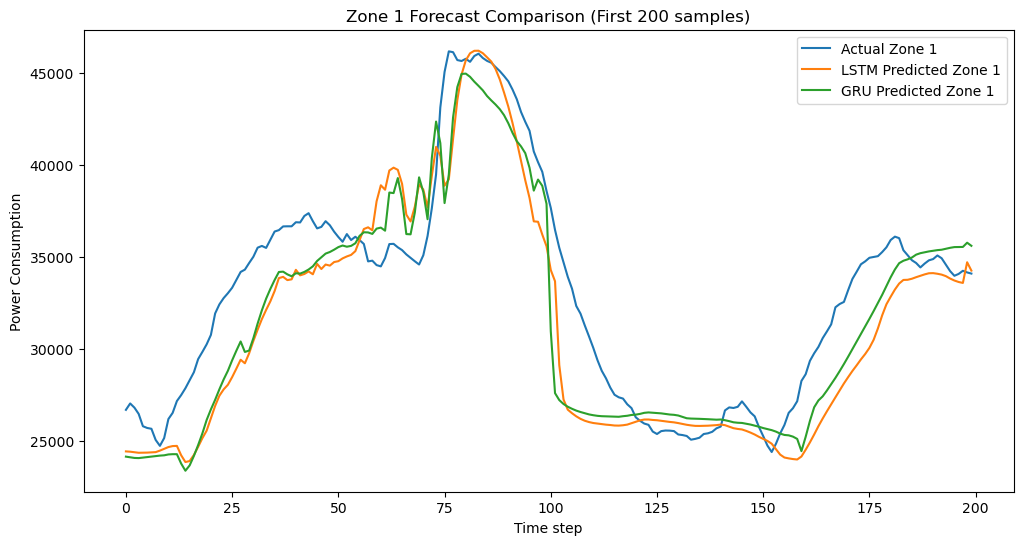

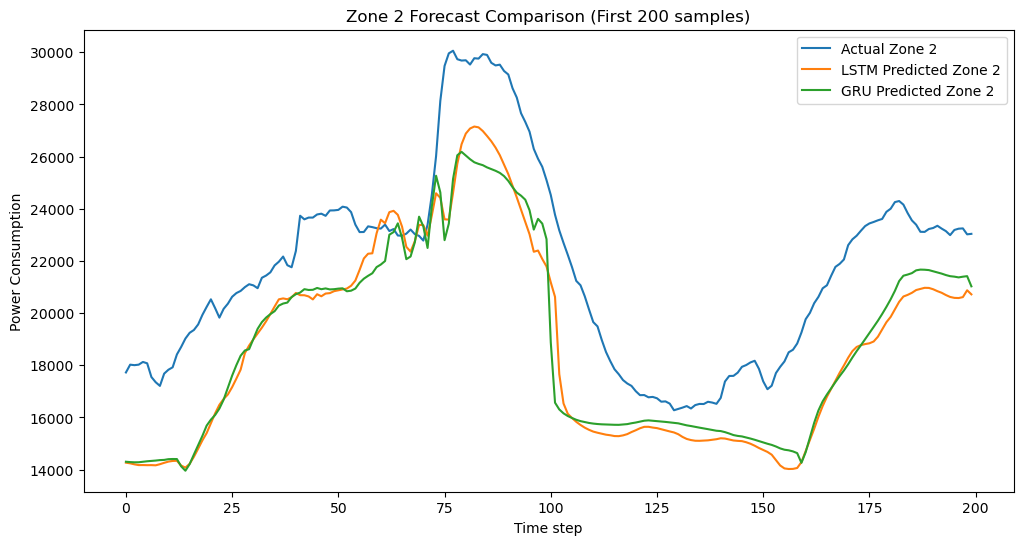

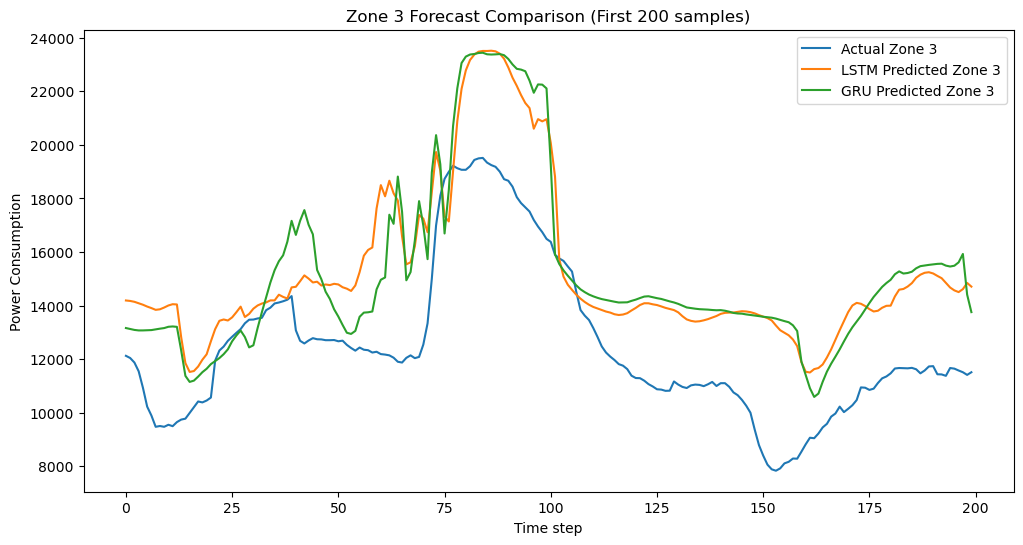

In [13]:
# =====================================================
# SECTION 9: Plot Forecast vs Real
# =====================================================
plt.figure(figsize=(12,6))
plt.plot(y_test_inv[:200,0], label='Actual Zone 1')
plt.plot(y_pred_lstm_inv[:200,0], label='LSTM Predicted Zone 1')
plt.plot(y_pred_gru_inv[:200,0], label='GRU Predicted Zone 1')
plt.title('Zone 1 Forecast Comparison (First 200 samples)')
plt.xlabel('Time step')
plt.ylabel('Power Consumption')
plt.legend()
plt.show()

plt.figure(figsize=(12,6))
plt.plot(y_test_inv[:200,1], label='Actual Zone 2')
plt.plot(y_pred_lstm_inv[:200,1], label='LSTM Predicted Zone 2')
plt.plot(y_pred_gru_inv[:200,1], label='GRU Predicted Zone 2')
plt.title('Zone 2 Forecast Comparison (First 200 samples)')
plt.xlabel('Time step')
plt.ylabel('Power Consumption')
plt.legend()
plt.show()

plt.figure(figsize=(12,6))
plt.plot(y_test_inv[:200,2], label='Actual Zone 3')
plt.plot(y_pred_lstm_inv[:200,2], label='LSTM Predicted Zone 3')
plt.plot(y_pred_gru_inv[:200,2], label='GRU Predicted Zone 3')
plt.title('Zone 3 Forecast Comparison (First 200 samples)')
plt.xlabel('Time step')
plt.ylabel('Power Consumption')
plt.legend()
plt.show()

## Section 10. Plot training loss
This section presents the evolution of the training and validation loss for the LSTM and GRU models over the epochs. The graphs allow for a comparison of the convergence speed and stability of the two models, providing a dashboard-like visual representation of their performance on the training and validation sets.

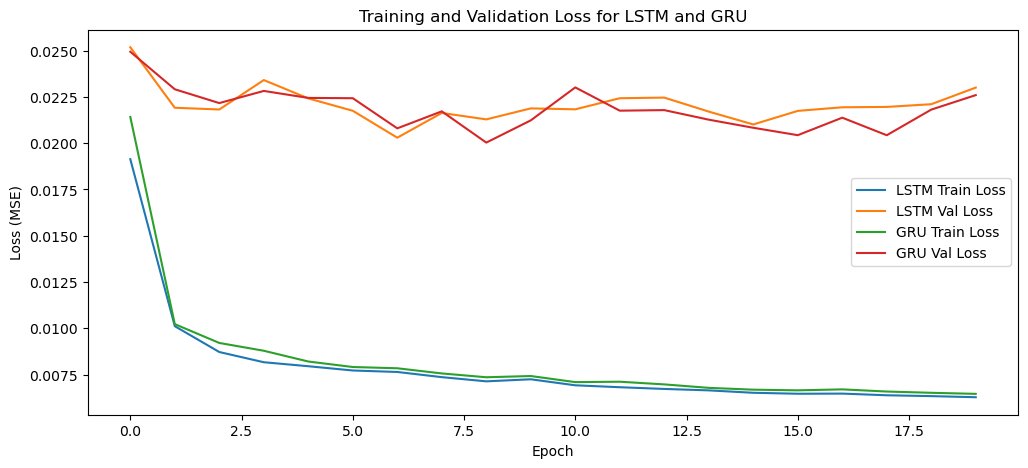

In [14]:
# =====================================================
# SECTION 10: Plot Training Loss (Dashboard-like)
# =====================================================
plt.figure(figsize=(12,5))
plt.plot(lstm_history.history['loss'], label='LSTM Train Loss')
plt.plot(lstm_history.history['val_loss'], label='LSTM Val Loss')
plt.plot(gru_history.history['loss'], label='GRU Train Loss')
plt.plot(gru_history.history['val_loss'], label='GRU Val Loss')
plt.title('Training and Validation Loss for LSTM and GRU')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.show()

# IV. Dataset
The data used in this notebook comes from the [Kaggle's Electric Power Consumption dataset](https://www.kaggle.com/datasets/fedesoriano/electric-power-consumption). This dataset is a CSV file with 3 columns of electric power consumption recorded at a frequency of 6 samples per hour (1 sample every 10 minutes). Each of these 3 columns represents a zone of the city of Tétouan, in Morocco.

**Features**:
* **Date Time**: Time window of ten minutes.
* **Temperature**: Weather Temperature.
* **Humidity**: Weather Humidity.
* **Wind Speed**: Wind Speed.
* **General Diffuse Flows**: “Diffuse flow” is a catchall term to describe low-temperature (< 0.2° to ~ 100°C) fluids that slowly discharge through sulfide mounds, fractured lava flows, and assemblages of bacterial mats and macrofauna.

**Target**:
*  **Zone 1 Power Consumption**
*  **Zone 2 Power Consumption**
*  **Zone 3 Power Consumption**

# VI. Conclusions

LSTM and GRU provide comparable performance in energy consumption forecasting. GRU trains faster and requires fewer parameters, while LSTM handles long-term dependencies more effectively and exhibits slightly higher stability on the validation set. Based on the implementation and experiments conducted, the following observations were made:

1. Predictive Performance

 - Both LSTM and GRU models were able to estimate energy consumption with a high degree of accuracy.

 - LSTM produced slightly more stable long-term predictions and managed longer input sequences more effectively, particularly in the presence of complex temporal dependencies.

 - GRU achieved comparable performance; however, it may exhibit minor variations when applied to longer forecasting horizons.

2. Training Speed and Model Complexity

 - GRU trained faster due to its simpler architecture and smaller number of parameters.

 - LSTM requires more computational resources and longer training time, but provides slightly improved stability on the validation datasets.

3. Numerical Results (MAE and MSE)

 - The MAE and MSE values obtained on the test set were similar for both models, confirming that GRU represents an efficient alternative when computational resources are limited.

 - LSTM generally achieved slightly lower MSE values in zones characterized by higher consumption variability.

4. Practical Recommendation

 - For large datasets or scenarios where training time is critical, GRU is the preferred choice.

 - For long-term forecasting and maximum stability, LSTM remains the optimal solution.

# VII. References 📝

Here I am going to reference some useful links that I have used to build this notebook

* Recurrent Newurolat Networks - https://d2l.ai/chapter_recurrent-neural-networks/index.html?authuser=0
* Kaggle LSTM - https://www.kaggle.com/code/nechbamohammed/electric-power-consumption-forecasting#VI.3.-LSTM-Model
* Special reference - https://www.kaggle.com/code/dimitreoliveira/deep-learning-for-time-series-forecasting
* Data Set - https://www.kaggle.com/datasets/fedesoriano/electric-power-consumption
